#  Mushroom Image Classifier using TensorFlow

This notebook builds an image classifier for ~200 mushroom species, each with ~8 images, using transfer learning and data augmentation. We use an 80/10/10 train/validation/test split.

# DATA SPLITTING

# DATA PROCESSING

In [20]:
import os
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.model_selection import train_test_split

# Paths
input_dir = '../data/data'
output_dir = '../data_augmented'
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

# Generation settings
generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Number of generated images per original
n_augmented = 3
test_ratio = 0.2  # 20% of images go to test set

# Ensure base directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Process each class
for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Prepare output subfolders
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Get list of image files
    img_list = [img for img in os.listdir(class_path) if not img.startswith('.')]
    train_imgs, test_imgs = train_test_split(img_list, test_size=test_ratio, random_state=42)

    # Copy test images directly (no augmentation)
    for img_name in test_imgs:
        src = os.path.join(class_path, img_name)
        dst = os.path.join(test_class_dir, img_name)
        shutil.copy2(src, dst)

    # Copy original training images and augment them
    for img_name in train_imgs:
        src = os.path.join(class_path, img_name)
        dst = os.path.join(train_class_dir, img_name)
        shutil.copy2(src, dst)  # Save original

        # Augment image
        try:
            img = load_img(src)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            i = 0
            for batch in generator.flow(x, batch_size=1, save_to_dir=train_class_dir, save_prefix='aug', save_format='jpeg'):
                i += 1
                if i >= n_augmented:
                    break
        except Exception as e:
            print(f"Error processing {src}: {e}")

print("Data split and augmentation complete!")


Data split and augmentation complete!


# BASIC MODEL 

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

def build_mobilenet_model(input_shape, num_classes, freeze_base=True):
    print('Building MobileNetV2 model...')
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    if freeze_base:
        print('Freezing base model layers...')
        for layer in base_model.layers:
            layer.trainable = False
    else:
        print('Unfreezing all base model layers...')
        for layer in base_model.layers:
            layer.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate(model, train_gen, val_data, val_labels, test_data, test_labels, epochs=30, model_name='model.h5'):
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    print('Training model...')
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=(val_data, val_labels),
        callbacks=[early_stop]
    )
    print('Evaluating on test set...')
    test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")
    print(f'Saving model to {model_name}...')
    model.save(model_name)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')
    plt.tight_layout()
    plt.show()

def mobilenet_workflow():
    augmented_dir = '../data_augmented'
    img_size = (128, 128)  # MobileNetV2 minimum size is 96x96
    batch_size = 32
    epochs = 30
    print('Loading data for MobileNetV2...')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    train_gen = datagen.flow_from_directory(
        augmented_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=42
    )
    val_test_gen = datagen.flow_from_directory(
        augmented_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=True,
        seed=42
    )
    val_samples = int(0.5 * val_test_gen.samples)
    test_samples = val_test_gen.samples - val_samples
    val_data, val_labels, test_data, test_labels = [], [], [], []
    for i in range(val_test_gen.samples):
        x, y = next(val_test_gen)
        for j in range(x.shape[0]):
            if i * batch_size + j < val_samples:
                val_data.append(x[j])
                val_labels.append(y[j])
            else:
                test_data.append(x[j])
                test_labels.append(y[j])
            if len(val_data) >= val_samples and len(test_data) >= test_samples:
                break
        if len(val_data) >= val_samples and len(test_data) >= test_samples:
            break
    val_data = np.array(val_data)
    val_labels = np.array(val_labels)
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    num_classes = train_gen.num_classes

    # Train with frozen base
    mobilenet_model = build_mobilenet_model(img_size + (3,), num_classes, freeze_base=True)
    train_and_evaluate(mobilenet_model, train_gen, val_data, val_labels, test_data, test_labels, epochs=epochs, model_name='mushroom_mobilenet_frozen.h5')

    # Unfreeze and fine-tune
    print('Unfreezing base model for fine-tuning...')
    for layer in mobilenet_model.layers:
        layer.trainable = True
    mobilenet_model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    train_and_evaluate(mobilenet_model, train_gen, val_data, val_labels, test_data, test_labels, epochs=10, model_name='mushroom_mobilenet_finetuned.h5')

mobilenet_workflow()

Found 7497 images belonging to 215 classes.
Found 1854 images belonging to 215 classes.
Found 1854 images belonging to 215 classes.


Found 7497 images belonging to 215 classes.
Found 1854 images belonging to 215 classes.
Found 1854 images belonging to 215 classes.


AttributeError: 'DirectoryIterator' object has no attribute 'next'

# WORKING ONE


Loading data for MobileNetV2...
Found 8069 images belonging to 215 classes.
Found 1866 images belonging to 215 classes.
Found 633 images belonging to 215 classes.
Training model...
Epoch 1/8
253/253 ━━━━━━━━━━━━━━━━━━━━ 56s 214ms/step - accuracy: 0.0501 - loss: 5.0701 - val_accuracy: 0.4609 - val_loss: 2.5144
Epoch 2/8
253/253 ━━━━━━━━━━━━━━━━━━━━ 57s 226ms/step - accuracy: 0.4547 - loss: 2.2935 - val_accuracy: 0.6913 - val_loss: 1.3669
Epoch 3/8
253/253 ━━━━━━━━━━━━━━━━━━━━ 90s 355ms/step - accuracy: 0.6952 - loss: 1.2060 - val_accuracy: 0.8055 - val_loss: 0.8606
Epoch 4/8
253/253 ━━━━━━━━━━━━━━━━━━━━ 79s 313ms/step - accuracy: 0.8146 - loss: 0.7457 - val_accuracy: 0.8473 - val_loss: 0.6375
Epoch 5/8
253/253 ━━━━━━━━━━━━━━━━━━━━ 90s 357ms/step - accuracy: 0.8799 - loss: 0.4712 - val_accuracy: 0.8880 - val_loss: 0.4917
Epoch 6/8
253/253 ━━━━━━━━━━━━━━━━━━━━ 94s 373ms/step - accuracy: 0.9216 - loss: 0.3149 - val_accuracy: 0.9009 - val_loss: 0.4277
Epoch 7/8
253/253 ━━━━━━━━━━━━━━━━━━━━ 

Test accuracy: 0.4502, Test loss: 2.6035
Saving model to mushroom_mobilenet_frozen.h5...


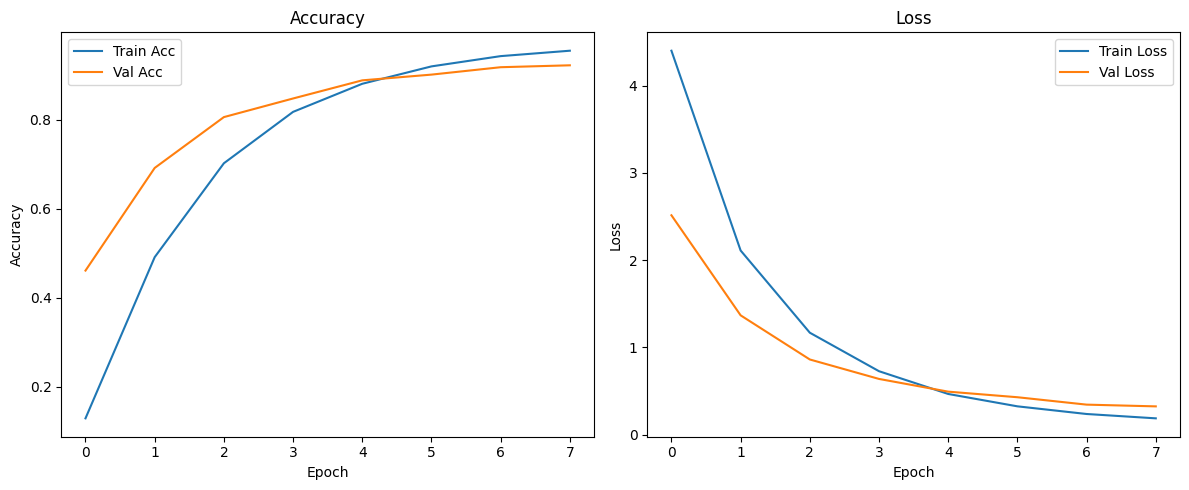

Unfreezing base model for fine-tuning...
Training model...
Epoch 1/10
 88/253 ━━━━━━━━━━━━━━━━━━━━ 1:50 667ms/step - accuracy: 0.3624 - loss: 2.8428

KeyboardInterrupt: 

In [29]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

def mobilenet_model(input_shape, num_classes, freeze_base=True):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = not freeze_base
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, train_gen, val_gen, epochs=30):
    print('Training model...')
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=[early_stop]
    )
    return history

def evaluate_model(model, history, test_gen, model_name):
    print('Evaluating on test set...')
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")
    print(f'Saving model to {model_name}...')
    model.save(model_name)
    # Plot
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')
    plt.tight_layout()
    plt.show()

def main():
    base_dir = '../data_augmented'
    train_dir = f'{base_dir}/train'
    test_dir = f'{base_dir}/test'

    img_size = (128, 128)
    batch_size = 32
    epochs = 8

    print('Loading data for MobileNetV2...')

    # Train/Validation split
    train_val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_gen = train_val_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=42
    )

    val_gen = train_val_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    # Separate test generator
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_gen = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    num_classes = train_gen.num_classes

    # Train with frozen base
    model = mobilenet_model(img_size + (3,), num_classes, freeze_base=True)
    history = train_model(model, train_gen, val_gen, epochs=epochs)
    evaluate_model(model, history, test_gen, model_name='mushroom_mobilenet_frozen.h5')

    # Fine-tune
    print('Unfreezing base model for fine-tuning...')
    for layer in model.layers:
        layer.trainable = True
    model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    history_finetuned = train_model(model, train_gen, val_gen, epochs=10)
    evaluate_model(model, history_finetuned, test_gen, model_name='mushroom_mobilenet_finetuned.h5')

if __name__ == '__main__':
    main()


Model: "functional_28"

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_28[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,918,986 (11.14 MB)

 Trainable params: 2,522,442 (9.62 MB)

 Non-trainable params: 396,544 (1.51 MB)

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_28[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,918,986 (11.14 MB)

 Trainable params: 2,522,442 (9.62 MB)

 Non-trainable params: 396,544 (1.51 MB)

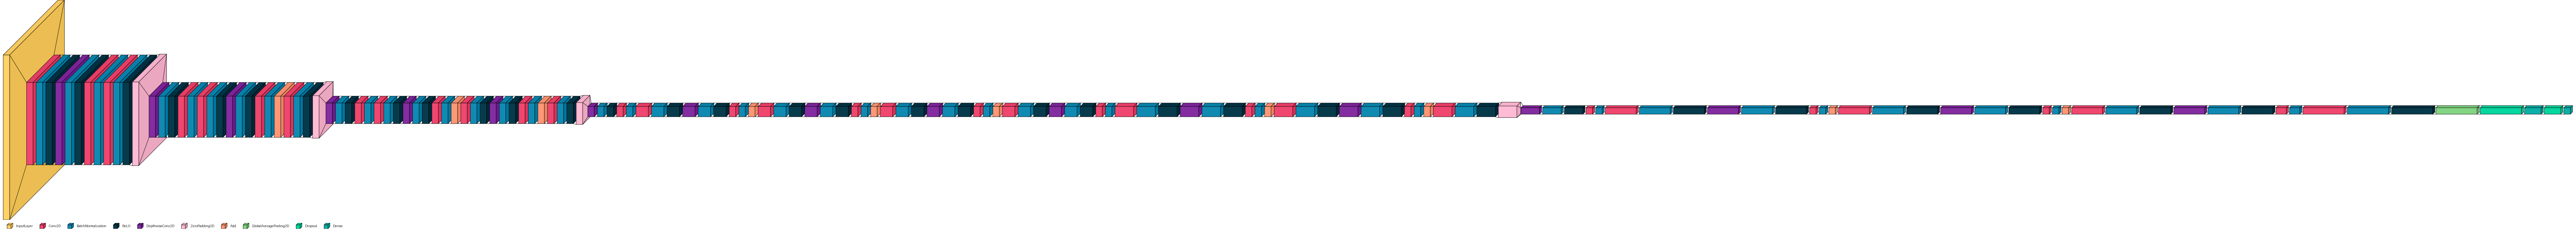

In [50]:
import visualkeras

def mobilenet_model1(image_size, num_classes, freeze_until=100):
    # Reset session
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=image_size)
    for i, layer in enumerate(base_model.layers):
        layer.trainable = False if i < freeze_until else True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.25)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['acc'])
    return model

mobilenet_model = mobilenet_model1((128, 128, 3), 10, freeze_until=100)
mobilenet_model.summary()
visualkeras.layered_view(mobilenet_model, legend = True, spacing = 10)


# MODEL PREDICTIONS

In [18]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# === Settings ===
model_path = 'mushroom_mobilenet_finetuned.h5'
data_dir = '../data_augmented'  # same as during training
img_size = (128, 128)

# === Step 1: Load model ===
model = load_model(model_path)

# === Step 2: Get class names from folder structure ===
datagen = ImageDataGenerator(rescale=1./255)
temp_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)
# class_indices: {'Amanita': 0, 'Boletus': 1, ...}
class_indices = temp_gen.class_indices
class_labels = list(class_indices.keys())

# === Step 3: Preprocess and Predict a new image ===
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_image(img_path):
    img_array = preprocess_image(img_path)
    preds = model.predict(img_array)
    class_idx = np.argmax(preds, axis=1)[0]
    label = class_labels[class_idx]
    confidence = preds[0][class_idx]
    return label, confidence

# === Step 4: Predict ===
img_path = '../tests/morel.jpg'
label, confidence = predict_image(img_path)
print(f"Predicted: {label} (Confidence: {confidence:.2f})")


Found 9351 images belonging to 215 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted: freckled_dapperling (Confidence: 0.57)


# TESTING

In [47]:
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

def build_mobilenet_model(input_shape=(128, 128, 3), num_classes=10, freeze_until=100):
    print(f'Building MobileNetV2 model with input shape {input_shape}...')
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    print(f'Freezing first {freeze_until} layers of the base model...')
    for i, layer in enumerate(base_model.layers):
        layer.trainable = False if i < freeze_until else True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def train_model(model, train_gen, val_data, val_labels, epochs=30):
    print('Training model...')
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=(val_data, val_labels),
        callbacks=[early_stop]
    )
    return history

def evaluate_model(model, history, test_data, test_labels, model_name):
    print('Evaluating on test set...')
    test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")
    print(f'Saving model to {model_name}...')
    model.save(model_name)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')
    plt.tight_layout()
    plt.show()

def main():
    augmented_dir = '../data_augmented'
    img_size = (128, 128) 
    batch_size = 32  
    epochs = 15
    print('Loading data for EfficientNetB5...')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    train_gen = datagen.flow_from_directory(
        augmented_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=42
    )
    val_test_gen = datagen.flow_from_directory(
        augmented_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=True,
        seed=42
    )
    val_samples = int(0.5 * val_test_gen.samples)
    test_samples = val_test_gen.samples - val_samples
    val_data, val_labels, test_data, test_labels = [], [], [], []
    for i in range(val_test_gen.samples):
        x, y = next(val_test_gen)
        for j in range(x.shape[0]):
            if i * batch_size + j < val_samples:
                val_data.append(x[j])
                val_labels.append(y[j])
            else:
                test_data.append(x[j])
                test_labels.append(y[j])
            if len(val_data) >= val_samples and len(test_data) >= test_samples:
                break
        if len(val_data) >= val_samples and len(test_data) >= test_samples:
            break
    val_data = np.array(val_data)
    val_labels = np.array(val_labels)
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    num_classes = train_gen.num_classes

    # Train with frozen base
    model = build_mobilenet_model(img_size + (3,), num_classes, freeze_until=10)
    history = train_model(model, train_gen, val_data, val_labels, epochs=epochs)
    evaluate_model(model, history, test_data, test_labels, model_name='mushroom_efficientnet_frozen.h5')

    # Fine-tuning
    print('Unfreezing base model for fine-tuning...')
    for layer in model.layers:
        layer.trainable = True
    model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    history_finetuned = train_model(model, train_gen, val_data, val_labels, epochs=10)
    evaluate_model(model, history_finetuned, test_data, test_labels, model_name='mushroom_efficientnet_finetuned.h5')

if __name__ == '__main__':
    main()


Loading data for EfficientNetB5...
Found 7497 images belonging to 215 classes.
Found 1854 images belonging to 215 classes.
Found 1854 images belonging to 215 classes.
Building MobileNetV2 model with input shape (128, 128, 3)...
Building MobileNetV2 model with input shape (128, 128, 3)...
Freezing first 10 layers of the base model...
Training model...
Epoch 1/15
Freezing first 10 layers of the base model...
Training model...
Epoch 1/15


Loading data for EfficientNetB5...
Found 7497 images belonging to 215 classes.
Found 1854 images belonging to 215 classes.
Found 1854 images belonging to 215 classes.
Building MobileNetV2 model with input shape (128, 128, 3)...
Building MobileNetV2 model with input shape (128, 128, 3)...
Freezing first 10 layers of the base model...
Training model...
Epoch 1/15
Freezing first 10 layers of the base model...
Training model...
Epoch 1/15


c:\Users\sinan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Loading data for EfficientNetB5...
Found 7497 images belonging to 215 classes.
Found 1854 images belonging to 215 classes.
Found 1854 images belonging to 215 classes.
Building MobileNetV2 model with input shape (128, 128, 3)...
Building MobileNetV2 model with input shape (128, 128, 3)...
Freezing first 10 layers of the base model...
Training model...
Epoch 1/15
Freezing first 10 layers of the base model...
Training model...
Epoch 1/15


c:\Users\sinan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


235/235 ━━━━━━━━━━━━━━━━━━━━ 119s 453ms/step - accuracy: 0.0056 - loss: 5.4327 - val_accuracy: 0.0076 - val_loss: 5.8215
Epoch 2/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 119s 453ms/step - accuracy: 0.0056 - loss: 5.4327 - val_accuracy: 0.0076 - val_loss: 5.8215
Epoch 2/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 106s 450ms/step - accuracy: 0.0179 - loss: 5.1388 - val_accuracy: 0.0151 - val_loss: 6.5480
Epoch 3/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 106s 450ms/step - accuracy: 0.0179 - loss: 5.1388 - val_accuracy: 0.0151 - val_loss: 6.5480
Epoch 3/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 105s 448ms/step - accuracy: 0.0326 - loss: 4.7750 - val_accuracy: 0.0054 - val_loss: 9.1562
Epoch 4/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 105s 448ms/step - accuracy: 0.0326 - loss: 4.7750 - val_accuracy: 0.0054 - val_loss: 9.1562
Epoch 4/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 105s 445ms/step - accuracy: 0.0421 - loss: 4.4910 - val_accuracy: 0.0140 - val_loss: 6.8093
Epoch 5/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 105s 445ms/step - accuracy: 0.0421 - loss: 4.49

Loading data for EfficientNetB5...
Found 7497 images belonging to 215 classes.
Found 1854 images belonging to 215 classes.
Found 1854 images belonging to 215 classes.
Building MobileNetV2 model with input shape (128, 128, 3)...
Building MobileNetV2 model with input shape (128, 128, 3)...
Freezing first 10 layers of the base model...
Training model...
Epoch 1/15
Freezing first 10 layers of the base model...
Training model...
Epoch 1/15


c:\Users\sinan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


235/235 ━━━━━━━━━━━━━━━━━━━━ 119s 453ms/step - accuracy: 0.0056 - loss: 5.4327 - val_accuracy: 0.0076 - val_loss: 5.8215
Epoch 2/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 119s 453ms/step - accuracy: 0.0056 - loss: 5.4327 - val_accuracy: 0.0076 - val_loss: 5.8215
Epoch 2/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 106s 450ms/step - accuracy: 0.0179 - loss: 5.1388 - val_accuracy: 0.0151 - val_loss: 6.5480
Epoch 3/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 106s 450ms/step - accuracy: 0.0179 - loss: 5.1388 - val_accuracy: 0.0151 - val_loss: 6.5480
Epoch 3/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 105s 448ms/step - accuracy: 0.0326 - loss: 4.7750 - val_accuracy: 0.0054 - val_loss: 9.1562
Epoch 4/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 105s 448ms/step - accuracy: 0.0326 - loss: 4.7750 - val_accuracy: 0.0054 - val_loss: 9.1562
Epoch 4/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 105s 445ms/step - accuracy: 0.0421 - loss: 4.4910 - val_accuracy: 0.0140 - val_loss: 6.8093
Epoch 5/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 105s 445ms/step - accuracy: 0.0421 - loss: 4.49

KeyboardInterrupt: 